<hr/>

# imports

In [ ]:
!pip install imblearn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute tf warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import math
import sklearn
import imblearn

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Definitions

In [3]:
def pipe(*funcs):
    """
    Works similar to the semantics of a `pipe` in other programming languages.
    Intended to make nested functions readable and easier to manipulate. It
    will take the first item in the list and feed it as input to the next
    function in the list, then it takes that output and feeds it as input to
    the next function in the list, and so on until it reaches the last
    function in the list and returns its output.

    Example:
        instead of this:
            ```py
            input_layer = Input(...)
            embedding_layer = Embedding(...)(input_layer)
            lstm_layer = LSTM(...)(embedding_layer)
            hidden_layer = Dense(...)(lstm_layer)
            output_layer = Dense(...)(hidden_layer)
            ```
        you can do this:
            ```py
            lstm_ouput = pipe(
                Input(...),
                Embedding(...),
                LSTM(...),
                Dense(...),
                Dense(...)
            )
            ```
    """
    out = funcs[0]
    for func in funcs[1:]:
        out = func(out)
    return out

In [4]:
def determine_name(row) -> str:
    """
    Auxilary function used to determine the label for each given row.
    """
    if row['sender_labels'] and row['receiver_labels']:
        return 'straightforward'
    elif not row['sender_labels'] and row['receiver_labels']:
        return 'deceive'
    elif row['sender_labels'] and not row['receiver_labels']:
        return 'cassandra'
    elif not row['sender_labels'] and not row['receiver_labels']:
        return 'caught'
    else:
        return None

In [5]:
def parse_jsonl(path: str) -> pd.DataFrame:
    """
    Load the given jsonl file and parse each conversation into a readable pandas
    data frame, where each row is a message. Additional data that is used later
    is also added to the created dataframe for consistency accross all loaded
    data.

    Args:
        path: str
            the path to the jsonl file to load and parse

    Returns: pd.DataFrame
        A parsed data frame where each row is a message.
    """
    data = {}
    with open(path, 'r') as f:
        for (i, line) in enumerate(f):
            line = json.loads(line)
            line["conversation_id"] = [i] * len(line["messages"])
            line['previous_message'] = ([""] if len(line['messages']) > 0 else []) + line["messages"][:-1]
            for k in line.keys():
                if k == "players":
                    continue
                if k == "game_id":
                    line[k] = [line[k]] * len(line["messages"])
                data[k] = data.get(k, []) + line[k]
    data = pd.DataFrame(data)
    data['label'] = data.apply(determine_name, axis=1)
    data['sender_labels_encoded'] = data['sender_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data['receiver_labels_encoded'] = data['receiver_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data["game_score_delta"] = data['game_score_delta'].astype(float)
    return data

In [6]:
def EvaluateModel(model: tf.keras.Sequential, test_ds: tf.data.Dataset, test_target: pd.DataFrame, history: tf.keras.callbacks.History, skip_evaluation: bool = False) -> tuple[float, float]:
    """
    Take the model and plot the training accuracy and validation accuracy. Also,
    Perform a evaluation on the test data, print the loss and accuracy, and print
    the test metric scores.

    Args:
        model: tf.keras.Sequential
            the model to test
        test_ds: tf.data.Dataset
            the test dataset to evaluate the model with
        test_target: pd.DataFrame
            the test data frame list with the target labels
        history: tf.keras.callbacks.History
            the history from fitting the model
        skip_evaluation: bool
            skip the model.evaluate() function
    """
    def find_best_threshold(y_true, y_probs):
        best_threshold = 0.5
        best_f1 = 0.0

        # Iterate over a range of thresholds (e.g., 0.0 to 1.0)
        for threshold in np.arange(0.0, 1.0, 0.01):
            # Convert probabilities to binary predictions based on the current threshold
            y_pred = (y_probs > threshold).astype(int)

            # Calculate the F1 score
            f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')

            # If this F1 score is better than the best so far, update the best threshold and F1 score
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        return best_threshold, best_f1

    print(f"{'='*10} Model Accuracy {'='*10}")
    plt.plot(history.history['sender_output_auc'], label='sender_output_auc', color="tan", linestyle="dashed")
    plt.plot(history.history['val_sender_output_auc'], label = 'val_sender_output_auc', color="darkorange")
    plt.plot(history.history['receiver_output_auc_1'], label='receiver_output_auc', color="cornflowerblue" , linestyle="dashed")
    plt.plot(history.history['val_receiver_output_auc_1'], label = 'val_receiver_output_auc', color="darkblue")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1.03])
    plt.legend(loc='lower right')
    plt.show()

    if not skip_evaluation:
        print(f"{'='*10} Test Evaluation {'='*10}")
        model.evaluate(test_ds, test_target, verbose=2)
        # print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")
        print()

    print(f"{'='*10} Test Metrics {'='*10}")
    y_pred = model.predict(test_ds)

    # Find the best threshold for sender
    best_threshold_sender, best_f1_sender = find_best_threshold(test_target[0], y_pred[0])
    print("Best Threshold for Sender:", best_threshold_sender, "with F1 Score:", best_f1_sender)

    # Find the best threshold for receiver
    best_threshold_receiver, best_f1_receiver = find_best_threshold(test_target[1], y_pred[1])
    print("Best Threshold for Receiver:", best_threshold_receiver, "with F1 Score:", best_f1_receiver)

      # Convert probabilities to binary predictions
    y_pred_sender = (y_pred[0] > best_threshold_sender).astype(int).reshape(-1)
    y_pred_receiver = (y_pred[1] > best_threshold_receiver).astype(int).reshape(-1)

    print()
    print(f"{'-'*10} Sender Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[0], y_pred_sender, target_names=["True", "False"], zero_division=0))
    print(f"{'-'*10} Receiver Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[1], y_pred_receiver, target_names=["True", "False"], zero_division=0))

    return best_threshold_sender, best_threshold_receiver

In [7]:
def Tokenize(tokenizer, df: pd.DataFrame, sequence_len: int = 300) -> tuple:
    """
    Makes a consistant return of tokenized and padded messages and previous messages.
    """
    encoded_msg = tokenizer.texts_to_sequences(df['messages'])
    encoded_prev_msg = tokenizer.texts_to_sequences(df['previous_message'])
    return keras.preprocessing.sequence.pad_sequences(encoded_msg, sequence_len), keras.preprocessing.sequence.pad_sequences(encoded_prev_msg, sequence_len)

In [8]:
def PredictionGridPeek(pred: list, df: pd.DataFrame, target_labels: list, who: str) -> pd.DataFrame:
    table = {
        "prediction": [],
        "target": [],
        "message": [],
        "context": []
    }
    for match in [True, False]:
        bool_stmt = pred == df[f'{who}_labels_encoded'] if match else pred != df[f'{who}_labels_encoded']
        visited = []
        for i in range(0, len(pred[bool_stmt])):
            row = df[bool_stmt].iloc[i,:]
            pred_label = target_labels[pred[bool_stmt][i]]
            if (pred_label, row[f'{who}_labels']) not in visited:
                table["prediction"].append(pred_label)
                table["target"].append(row[f'{who}_labels'])
                table['message'].append(row['messages'])
                table['context'].append(row['previous_message'])
                visited.append((pred_label, row[f'{who}_labels']))
                if len(visited) >= len(target_labels):
                    break
    return pd.DataFrame(table)

<hr/>

# data explortion

just a raw load of the data we can see it is unformated and needs to be parsed a little to better satisfy the pandas format.

## NOANNOTATION

In [9]:
# train_df = (parse_jsonl("./data/train.jsonl"))
# test_df = (parse_jsonl("./data/test.jsonl"))
# validation_df = (parse_jsonl("./data/validation.jsonl"))

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/Colab Notebooks/w266 Final Project'

train_df = (parse_jsonl(f"{folder_path}/data/train.jsonl"))
test_df = (parse_jsonl(f"{folder_path}/data/test.jsonl"))
validation_df = (parse_jsonl(f"{folder_path}/data/validation.jsonl"))

Mounted at /content/drive


In [10]:
train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,italy,germany,89,4,Spring,1901,3,0.0,1,0,It seems like there are a lot of ways that cou...,straightforward,0,2


# NOANNOTATION

We can see that there are some `receiver_labels` that have the value `NOANNOTATION`. this is not a bool value

In [11]:
print("NOANNOTATION percentage in:")
print(f'train = {(len(train_df[train_df["receiver_labels"] == "NOANNOTATION"].index) /  len(train_df.index)) * 100:.2f}%')
print(f'test = {(len(test_df[test_df["receiver_labels"] == "NOANNOTATION"].index) /  len(test_df.index)) * 100:.2f}%')
print(f'validation = {(len(validation_df[validation_df["receiver_labels"] == "NOANNOTATION"].index) /  len(validation_df.index)) * 100:.2f}%')

NOANNOTATION percentage in:
train = 8.43%
test = 9.70%
validation = 9.39%


The percentages are low in each dataset and "NOANNOTATION" does not provide any meaningful value so we will remove it to keep the results a boolean value `True` or `False`.

In [12]:
train_df = train_df[train_df["receiver_labels"] != "NOANNOTATION"]
test_df = test_df[test_df['receiver_labels'] != "NOANNOTATION"]
validation_df = validation_df[validation_df['receiver_labels'] != "NOANNOTATION"]

# Unique Words

In [13]:
sequence_list = list(train_df['messages'].astype(str).str.lower().str.split().to_numpy())
unique_words = {}
for sequence in sequence_list:
    for word in sequence:
        unique_words[word] = unique_words.get(word, 0) + 1
    # sequence_list = sequence_list + (["<PAD>"] )

for (i,(k,v)) in enumerate(unique_words.items()):
    if i > 30:
        break
    print(f"{k}: {v}")

germany!: 11
just: 1146
the: 6037
person: 28
i: 8250
want: 779
to: 10653
speak: 17
with.: 34
have: 1944
a: 4399
somewhat: 15
crazy: 15
idea: 89
that: 3414
i’ve: 139
always: 75
wanted: 136
try: 284
with: 2364
i/g,: 1
but: 2086
never: 96
actually: 195
convinced: 11
other: 271
guy: 29
it.: 244
and,: 34
what’s: 73
worse,: 3


In [14]:
len(unique_words)

14991

<!-- I processed only what is considered a **word** to the regex `\w+`. this means that any punctuation is omitted. -->

After processing, we have a total of 15,657 words.

Some things to note are
- there are some arbitrary number included
- some words are repeated because of long character exaggeration (for example, "aaaaaalllllllllll" instead of "all" or "aaaaany" instead of "any")
- some words are repeated because of misspellings and typos

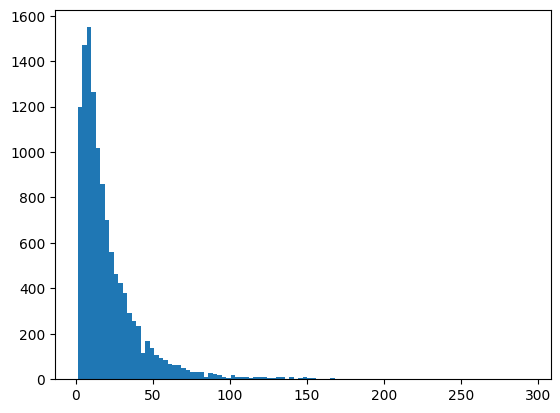

In [15]:
plt.hist(list(map(len, sequence_list)),bins=100)
plt.show()

In [16]:
summary = {
    "": [
        'Message count',
        'Average words per message',
        'Unique word count',
        'Actual Lie count',
        'Actual Truth count'
    ],
    "value": [
        len(train_df.index),
        math.floor(sum(map(len, sequence_list)) / len(sequence_list)),
        len(unique_words),
        (~train_df['sender_labels']).sum(),
        (train_df['sender_labels']).sum()
    ],
}
pd.DataFrame(summary)

,,value
0,Message count,12025
1,Average words per message,20
2,Unique word count,14991
3,Actual Lie count,545
4,Actual Truth count,11480


# Label count

In [17]:
train_df['label'].value_counts()

straightforward    10979
cassandra            501
deceive              480
caught                65
Name: label, dtype: int64

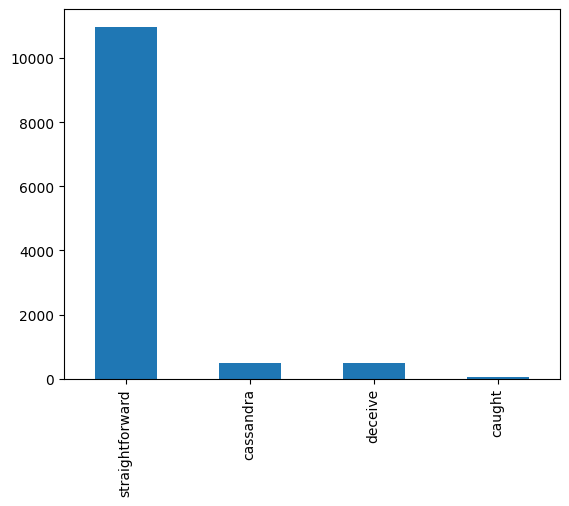

In [18]:
train_df['label'].value_counts().plot.bar()
plt.show()

In [19]:
train_df['label'].value_counts(normalize=True)

straightforward    0.913015
cassandra          0.041663
deceive            0.039917
caught             0.005405
Name: label, dtype: float64

<hr/>

# Constants

In [20]:
MAX_SEQUENCE_LEN = max(map(len,sequence_list))
VOCAB_SIZE = 5000 # len(unique_words)
EMBEDDING_OUTPUT_SIZE = 124
LSTM_SIZE = 64
DROPOUT_RATE = 0.2
HIDDEN_LAYER_SIZE = 64
LEARNING_RATE = 0.001

CLASS_LABELS = ["True", "False"]

tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])
# smote = imblearn.over_sampling.SMOTE()

# train_encoded_padded, y_train = smote.fit_resample(train_tokenized_padded, train_df['label_encoded'])
# train_prev_encoded_padded, y_train = smote.fit_resample(train_prev_tokenized_padded, train_df['label_encoded'])

train_encoded_padded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

# Naive Bayes Baseline

In [55]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# CountVectorizer and TfidfTransformer
count_vect = CountVectorizer(max_features=VOCAB_SIZE)
tf_transformer = TfidfTransformer(use_idf=False)

# Process for sender labels
X_train_sender = count_vect.fit_transform(train_df['messages'])
X_train_sender_tf = tf_transformer.fit_transform(X_train_sender)
y_train_sender = train_df['sender_labels_encoded']

# Process for receiver labels
X_train_receiver = count_vect.fit_transform(train_df['messages'])
X_train_receiver_tf = tf_transformer.fit_transform(X_train_receiver)
y_train_receiver = train_df['receiver_labels_encoded']


# Initialize SMOTE
oversample = SMOTE()

# Apply SMOTE for sender labels
X_train_sender_smote, y_train_sender_smote = oversample.fit_resample(X_train_sender_tf, y_train_sender)
clf_sender = MultinomialNB().fit(X_train_sender_smote, y_train_sender_smote)

# Apply SMOTE for receiver labels
X_train_receiver_smote, y_train_receiver_smote = oversample.fit_resample(X_train_receiver_tf, y_train_receiver)
clf_receiver = MultinomialNB().fit(X_train_receiver_smote, y_train_receiver_smote)

X_test = count_vect.transform(test_df['messages'])
X_test_tf = tf_transformer.transform(X_test)
y_test_sender = test_df['sender_labels_encoded']
y_test_receiver = test_df['receiver_labels_encoded']


# Evaluation for sender labels
y_test_pred_sender = clf_sender.predict(X_test_tf)
print("Test Metrics for Sender Labels")
print(metrics.classification_report(y_test_sender, y_test_pred_sender))

# Evaluation for receiver labels
y_test_pred_receiver = clf_receiver.predict(X_test_tf)
print("Test Metrics for Receiver Labels")
print(metrics.classification_report(y_test_receiver, y_test_pred_receiver))


Test Metrics for Sender Labels
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      2268
           1       0.11      0.43      0.18       207

    accuracy                           0.67      2475
   macro avg       0.52      0.56      0.48      2475
weighted avg       0.86      0.67      0.74      2475

Test Metrics for Receiver Labels
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      2310
           1       0.09      0.39      0.15       165

    accuracy                           0.70      2475
   macro avg       0.52      0.56      0.48      2475
weighted avg       0.89      0.70      0.78      2475



<hr/>

# Naive Neural Network

In [21]:
def create_naive_model(
        vocab_size: int = VOCAB_SIZE,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        sequence_length: int = MAX_SEQUENCE_LEN,
        hidden_size: int = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')

    naive_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden_size, activation="relu")
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(naive_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(naive_output)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return model

In [22]:
naive_model = create_naive_model()
naive_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 flatten (Flatten)           (None, 36456)                0         ['embedding[0][0]']           
                                                                                                  
 dense (Dense)               (None, 64)                   2333248   ['flatten[0][0]']             
                                                                                              

In [23]:
naive_history = naive_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 34s 71ms/step - loss: 0.3853 - sender_output_loss: 0.1870 - receiver_output_loss: 0.1983 - sender_output_auc: 0.5879 - receiver_output_auc_1: 0.5302 - val_loss: 0.3383 - val_sender_output_loss: 0.1761 - val_receiver_output_loss: 0.1622 - val_sender_output_auc: 0.6277 - val_receiver_output_auc_1: 0.5273
Epoch 2/10
376/376 [==============================] - 7s 18ms/step - loss: 0.2746 - sender_output_loss: 0.1219 - receiver_output_loss: 0.1527 - sender_output_auc: 0.8870 - receiver_output_auc_1: 0.8272 - val_loss: 0.3973 - val_sender_output_loss: 0.2219 - val_receiver_output_loss: 0.1754 - val_sender_output_auc: 0.5254 - val_receiver_output_auc_1: 0.5605
Epoch 3/10
376/376 [==============================] - 5s 12ms/step - loss: 0.1286 - sender_output_loss: 0.0514 - receiver_output_loss: 0.0772 - sender_output_auc: 0.9844 - receiver_output_auc_1: 0.9703 - val_loss: 0.4729 - val_sender_output_loss: 0.2560 - val_receiver_output_loss: 0.2

========== Model Accuracy ==========


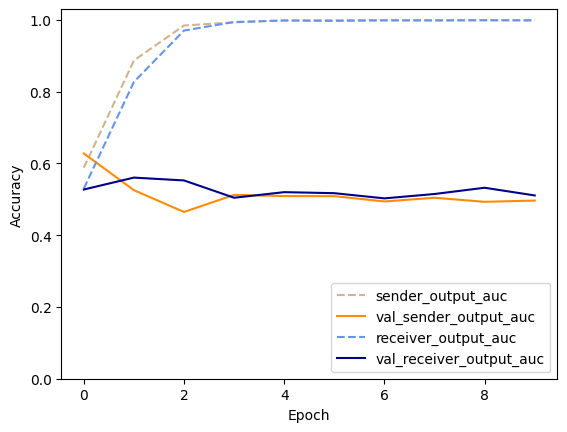

========== Test Evaluation ==========
78/78 - 0s - loss: 1.9264 - sender_output_loss: 1.1029 - receiver_output_loss: 0.8236 - sender_output_auc: 0.5138 - receiver_output_auc_1: 0.5121 - 227ms/epoch - 3ms/step

========== Test Metrics ==========
78/78 [==============================] - 0s 2ms/step
Best Threshold for Sender: 0.01 with F1 Score: 0.5132404004712201
Best Threshold for Receiver: 0.05 with F1 Score: 0.5165206228721326

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.95      0.94      2268
       False       0.12      0.07      0.09       207

    accuracy                           0.88      2475
   macro avg       0.52      0.51      0.51      2475
weighted avg       0.85      0.88      0.86      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.96      0.95      2310
       False       0.11      0.07      0.09       165

  

In [24]:
EvaluateModel(naive_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_history);

# Naive LSTM

In [25]:
def create_naive_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-4,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')

    naive_lstm_ouput = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(naive_lstm_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(naive_lstm_ouput)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return model

In [26]:
naive_lstm_model = create_naive_lstm_model()
naive_lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 lstm (LSTM)                 (None, 64)                   48384     ['embedding_1[0][0]']         
                                                                                                  
 dense_1 (Dense)             (None, 64)                   4160      ['lstm[0][0]']                
                                                                                            

In [27]:
naive_lstm_history = naive_lstm_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 26s 59ms/step - loss: 0.4768 - sender_output_loss: 0.2326 - receiver_output_loss: 0.2442 - sender_output_auc: 0.5652 - receiver_output_auc_1: 0.5087 - val_loss: 0.3215 - val_sender_output_loss: 0.1615 - val_receiver_output_loss: 0.1600 - val_sender_output_auc: 0.6361 - val_receiver_output_auc_1: 0.4824
Epoch 2/10
376/376 [==============================] - 8s 23ms/step - loss: 0.3674 - sender_output_loss: 0.1791 - receiver_output_loss: 0.1883 - sender_output_auc: 0.6299 - receiver_output_auc_1: 0.5710 - val_loss: 0.3210 - val_sender_output_loss: 0.1599 - val_receiver_output_loss: 0.1611 - val_sender_output_auc: 0.6509 - val_receiver_output_auc_1: 0.4710
Epoch 3/10
376/376 [==============================] - 8s 21ms/step - loss: 0.3495 - sender_output_loss: 0.1674 - receiver_output_loss: 0.1821 - sender_output_auc: 0.7256 - receiver_output_auc_1: 0.6581 - val_loss: 0.3267 - val_sender_output_loss: 0.1607 - val_receiver_output_loss: 0.1

========== Model Accuracy ==========


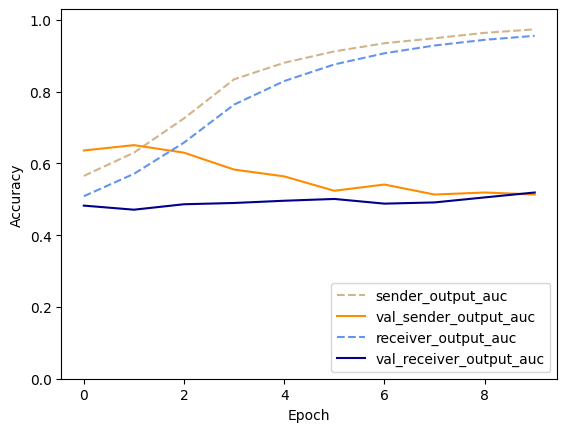

========== Test Evaluation ==========
78/78 - 0s - loss: 1.0915 - sender_output_loss: 0.6547 - receiver_output_loss: 0.4368 - sender_output_auc: 0.5377 - receiver_output_auc_1: 0.5246 - 487ms/epoch - 6ms/step

========== Test Metrics ==========
78/78 [==============================] - 1s 5ms/step
Best Threshold for Sender: 0.11 with F1 Score: 0.5502310852027433
Best Threshold for Receiver: 0.13 with F1 Score: 0.5323341234947543

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.93      0.93      2268
       False       0.18      0.17      0.17       207

    accuracy                           0.87      2475
   macro avg       0.55      0.55      0.55      2475
weighted avg       0.86      0.87      0.86      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.92      0.93      2310
       False       0.12      0.15      0.13       165

  

In [28]:
EvaluateModel(naive_lstm_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_lstm_history);

<hr/>

# Context lstm

In [29]:
def create_context_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    context_lstm_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_lstm_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_lstm_ouput)

    context_lstm_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_lstm_model

In [30]:
context_lstm_model = create_context_lstm_model()
context_lstm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_2 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                       

In [31]:
context_lstm_history = context_lstm_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 56s 134ms/step - loss: 0.4721 - sender_output_loss: 0.2315 - receiver_output_loss: 0.2406 - sender_output_auc: 0.5501 - receiver_output_auc_1: 0.5083 - val_loss: 0.3218 - val_sender_output_loss: 0.1623 - val_receiver_output_loss: 0.1595 - val_sender_output_auc: 0.6024 - val_receiver_output_auc_1: 0.4333
Epoch 2/10
376/376 [==============================] - 40s 105ms/step - loss: 0.3740 - sender_output_loss: 0.1825 - receiver_output_loss: 0.1915 - sender_output_auc: 0.5921 - receiver_output_auc_1: 0.5115 - val_loss: 0.3222 - val_sender_output_loss: 0.1636 - val_receiver_output_loss: 0.1586 - val_sender_output_auc: 0.6082 - val_receiver_output_auc_1: 0.4418
Epoch 3/10
376/376 [==============================] - 38s 101ms/step - loss: 0.3742 - sender_output_loss: 0.1833 - receiver_output_loss: 0.1909 - sender_output_auc: 0.5710 - receiver_output_auc_1: 0.5267 - val_loss: 0.3222 - val_sender_output_loss: 0.1622 - val_receiver_output_loss

========== Model Accuracy ==========


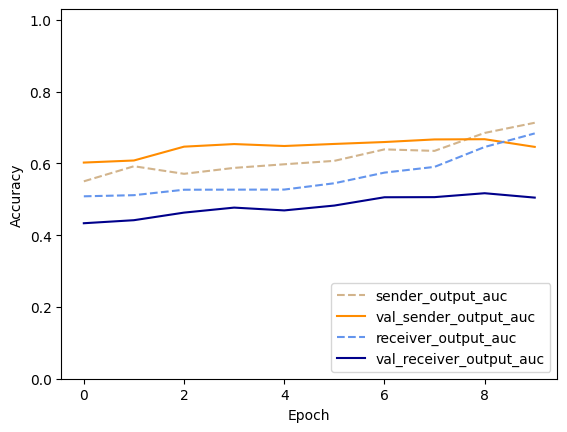

========== Test Evaluation ==========
78/78 - 3s - loss: 0.5200 - sender_output_loss: 0.2801 - receiver_output_loss: 0.2398 - sender_output_auc: 0.6693 - receiver_output_auc_1: 0.6180 - 3s/epoch - 37ms/step

========== Test Metrics ==========
78/78 [==============================] - 3s 34ms/step
Best Threshold for Sender: 0.08 with F1 Score: 0.5723931508192588
Best Threshold for Receiver: 0.1 with F1 Score: 0.5450822564802343

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.84      0.89      2268
       False       0.19      0.40      0.26       207

    accuracy                           0.81      2475
   macro avg       0.56      0.62      0.57      2475
weighted avg       0.88      0.81      0.84      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.95      0.95      2310
       False       0.17      0.13      0.14       165

    

In [32]:
sender_threshold, receiver_threshold = EvaluateModel(context_lstm_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_history)

# LSTM + Power

In [33]:
def create_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    lstm_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    lstm_power_ouput = pipe(
        [
            lstm_output,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(lstm_power_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(lstm_power_ouput)

    lstm_power_model = keras.Model(
        inputs=[message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    lstm_power_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return lstm_power_model

In [34]:
lstm_power_model = create_lstm_power_model()
lstm_power_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 embedding_4 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                             
                                                                                                  
 lstm_3 (LSTM)               (None, 1024)                 4706304   ['embedding_4[0][0]']         
                                                                                            

In [35]:
lstm_power_history = context_lstm_model.fit(
    [train_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 25s 59ms/step - loss: 0.3628 - sender_output_loss: 0.1749 - receiver_output_loss: 0.1879 - sender_output_auc: 0.6724 - receiver_output_auc_1: 0.5886 - val_loss: 0.3291 - val_sender_output_loss: 0.1633 - val_receiver_output_loss: 0.1659 - val_sender_output_auc: 0.6689 - val_receiver_output_auc_1: 0.4767
Epoch 2/10
376/376 [==============================] - 20s 54ms/step - loss: 0.3587 - sender_output_loss: 0.1726 - receiver_output_loss: 0.1861 - sender_output_auc: 0.6881 - receiver_output_auc_1: 0.6122 - val_loss: 0.3199 - val_sender_output_loss: 0.1587 - val_receiver_output_loss: 0.1612 - val_sender_output_auc: 0.6727 - val_receiver_output_auc_1: 0.4638
Epoch 3/10
376/376 [==============================] - 20s 54ms/step - loss: 0.3535 - sender_output_loss: 0.1694 - receiver_output_loss: 0.1841 - sender_output_auc: 0.7108 - receiver_output_auc_1: 0.6361 - val_loss: 0.3210 - val_sender_output_loss: 0.1586 - val_receiver_output_loss: 0

========== Model Accuracy ==========


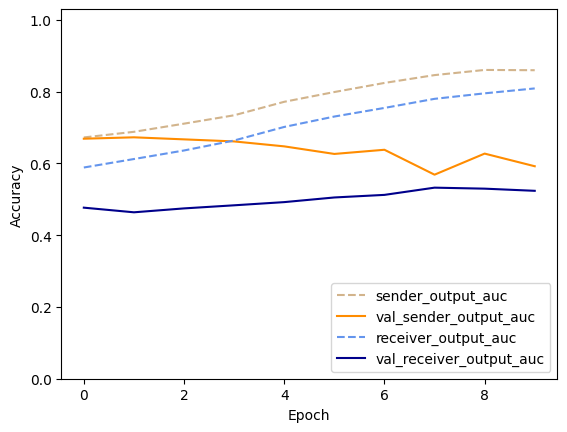

========== Test Evaluation ==========
78/78 - 3s - loss: 1.3849 - sender_output_loss: 0.6947 - receiver_output_loss: 0.6903 - sender_output_auc: 0.4410 - receiver_output_auc_1: 0.4506 - 3s/epoch - 34ms/step

========== Test Metrics ==========
78/78 [==============================] - 2s 17ms/step
Best Threshold for Sender: 0.54 with F1 Score: 0.48357314063146484
Best Threshold for Receiver: 0.56 with F1 Score: 0.48469817039142116

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.99      0.95      2268
       False       0.06      0.01      0.02       207

    accuracy                           0.91      2475
   macro avg       0.49      0.50      0.48      2475
weighted avg       0.84      0.91      0.87      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.99      0.96      2310
       False       0.03      0.01      0.01       165

 

In [36]:
EvaluateModel(lstm_power_model, [test_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], lstm_power_history);

# Context LSTM + Power

In [37]:
def create_context_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    context_lstm_power_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_lstm_power_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_lstm_power_ouput)

    context_lstm_power_model = keras.Model(
        inputs=[current_message_input, previous_message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_power_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_lstm_power_model

In [38]:
context_lstm_power_model = create_context_lstm_power_model()
context_lstm_power_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_5 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                       

In [39]:
context_lstm_power_history = context_lstm_power_model.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 55s 135ms/step - loss: 0.4641 - sender_output_loss: 0.2272 - receiver_output_loss: 0.2369 - sender_output_auc: 0.5506 - receiver_output_auc_1: 0.5118 - val_loss: 0.3238 - val_sender_output_loss: 0.1618 - val_receiver_output_loss: 0.1620 - val_sender_output_auc: 0.6203 - val_receiver_output_auc_1: 0.4965
Epoch 2/10
376/376 [==============================] - 40s 107ms/step - loss: 0.3744 - sender_output_loss: 0.1834 - receiver_output_loss: 0.1910 - sender_output_auc: 0.5683 - receiver_output_auc_1: 0.5336 - val_loss: 0.3273 - val_sender_output_loss: 0.1638 - val_receiver_output_loss: 0.1635 - val_sender_output_auc: 0.6338 - val_receiver_output_auc_1: 0.5076
Epoch 3/10
376/376 [==============================] - 38s 101ms/step - loss: 0.3719 - sender_output_loss: 0.1818 - receiver_output_loss: 0.1902 - sender_output_auc: 0.5992 - receiver_output_auc_1: 0.5439 - val_loss: 0.3198 - val_sender_output_loss: 0.1615 - val_receiver_output_loss

========== Model Accuracy ==========


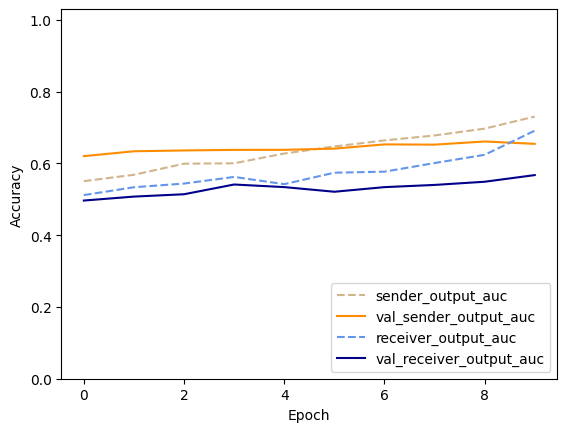

========== Test Evaluation ==========
78/78 - 3s - loss: 0.5111 - sender_output_loss: 0.2735 - receiver_output_loss: 0.2375 - sender_output_auc: 0.6698 - receiver_output_auc_1: 0.6341 - 3s/epoch - 37ms/step

========== Test Metrics ==========
78/78 [==============================] - 4s 34ms/step
Best Threshold for Sender: 0.14 with F1 Score: 0.5752239728143342
Best Threshold for Receiver: 0.14 with F1 Score: 0.5431175076889492

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.91      0.92      2268
       False       0.21      0.26      0.23       207

    accuracy                           0.85      2475
   macro avg       0.57      0.58      0.58      2475
weighted avg       0.87      0.85      0.86      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.96      0.95      2310
       False       0.18      0.11      0.14       165

   

In [40]:
EvaluateModel(context_lstm_power_model, [test_encoded_padded, test_prev_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_power_history);

<hr/>

# Context LSTM Prediction Analysis

In [41]:
pred = context_lstm_model.predict([test_encoded_padded, test_prev_encoded_padded])
sender_pred = (pred[0] > sender_threshold).astype(int).reshape(-1)
receiver_pred = (pred[1] > receiver_threshold).astype(int).reshape(-1)

display(sender_pred)
display(receiver_pred)

78/78 [==============================] - 3s 34ms/step


array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

## Sender Predictions

In [42]:
sender_table = PredictionGridPeek(sender_pred, test_df, CLASS_LABELS, "sender")
sender_table

,prediction,target,message,context
0,True,True,"Hi Italy! Just opening up communication, and I...",
1,False,False,Hello! I'm looking forward to a fun game as we...,Hey Germany! How’s it going? Looking forward t...
2,True,False,"I'd personally rather you didn't, because a pl...","Bongiorno! To crush my enemies, see them driv..."
3,False,True,So I tried to move towards a more forward posi...,"Also, weirdly, my phone doesn't seem to be upd..."


In [43]:
sender_table["message"].map(display);

'Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together'

"Hello! I'm looking forward to a fun game as well. I usually see good things happen when Russia and Germany work together, so I hope we can both help each other in our initial plans. I'm assuming you're gonna try and attack Scandinavia first? Let me know your thoughts, and I look forward to us working well together"

"I'd personally rather you didn't, because a play around Munich is also a play around Trieste and Vienna. I've heard that there's some rancor over in the West and you might be able to profit from a mobbed France if you went that way."

'So I tried to move towards a more forward position so I could fight France an d stab Russia, and *not* fight you, but you’re kinda putting yourself directly in my way, y’know?'

In [45]:
sender_table["context"].map(display);

''

'Hey Germany! How’s it going? Looking forward to a fun game!'

'Bongiorno!  To crush my enemies, see them driven before me, and hear the lamentations of their women!  I mean, umm, not really sure yet.  Pondering whether or not to make an early play around Munich'

"Also, weirdly, my phone doesn't seem to be updating me with latest messages the way it should, so I end up seeing these a lot later than I should"

## Receiver Predictions

In [46]:
receiver_table = PredictionGridPeek(receiver_pred, test_df, CLASS_LABELS, "receiver")
receiver_table

,prediction,target,message,context
0,True,True,"Hi Italy! Just opening up communication, and I...",
1,False,False,"Oh, gdi. Now I have to tell a truth that soun...","Thanks, let's have a good game!"
2,True,False,"Well, if you want to attack France in the Medi...","Well....that's a great question, and a lot of ..."
3,False,True,So I tried to move towards a more forward posi...,"Also, weirdly, my phone doesn't seem to be upd..."


In [47]:
receiver_table["message"].map(display);

'Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together'

"Oh, gdi.  Now I have to tell a truth that sounds like the most cliched lie in the game: my order update didn't take, I wasn't intending to go to Piedmont.  Yes, I know it sounds ridiculous, but in this case true."

'Well, if you want to attack France in the Mediterranean while I attack through Burgundy you can have Marseille and Iberia while I take Brest and Paris, then with France out of the way you could focus on Turkey or Austria. Sound fair?'

'So I tried to move towards a more forward position so I could fight France an d stab Russia, and *not* fight you, but you’re kinda putting yourself directly in my way, y’know?'

In [48]:
receiver_table["context"].map(display);

''

"Thanks, let's have a good game!"

"Well....that's a great question, and a lot of it comes down to how free I'll be left to play in the West, no?"

"Also, weirdly, my phone doesn't seem to be updating me with latest messages the way it should, so I end up seeing these a lot later than I should"